# Logistic model

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [50]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(20) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [2]:
mice_diss = []
for mouse in range(1,9): 
    df = mi.get_dissimilarities(mouse, write = False)
    mice_diss.append(df)

Let's now have a graphical visualization of these dissimilarities

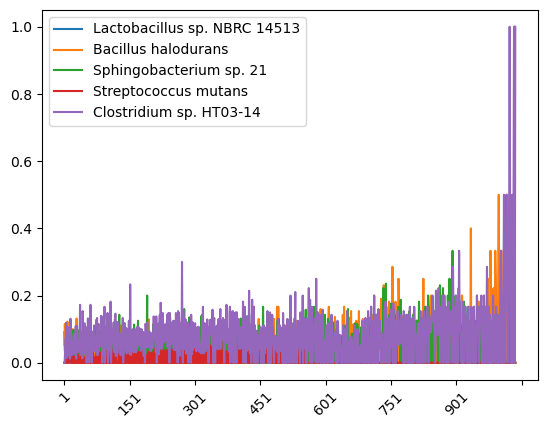

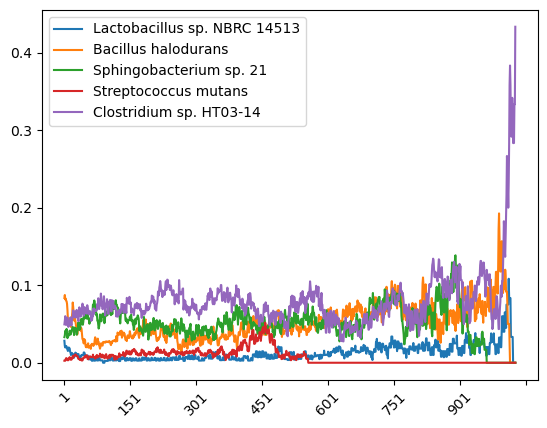

In [3]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   


In [ ]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

Plots saved in Inspection_Outputs/dissimilarity_1_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_2_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_3_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_4_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_5_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_6_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_7_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_8_plot.pdf


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [4]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

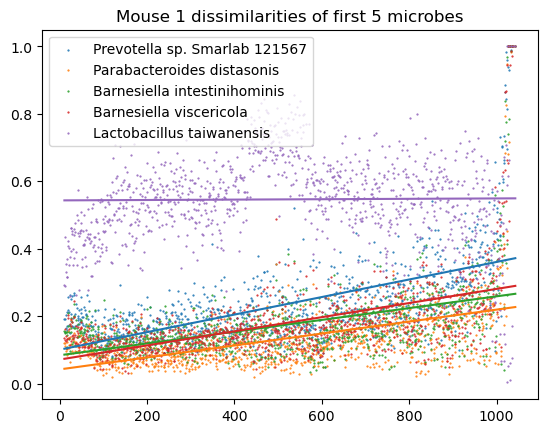

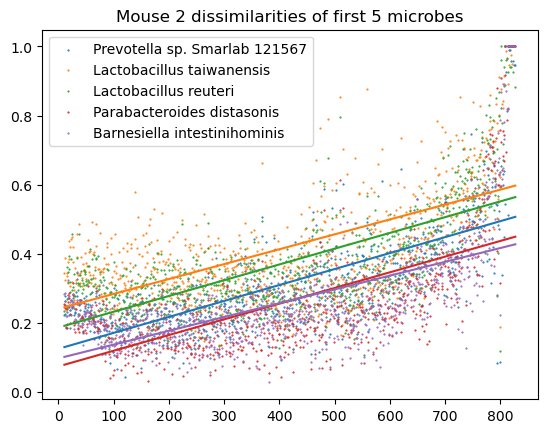

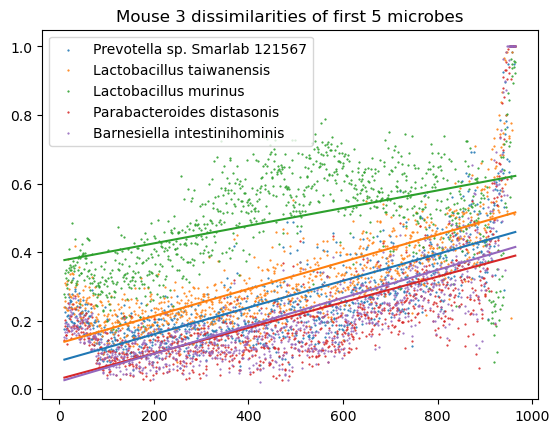

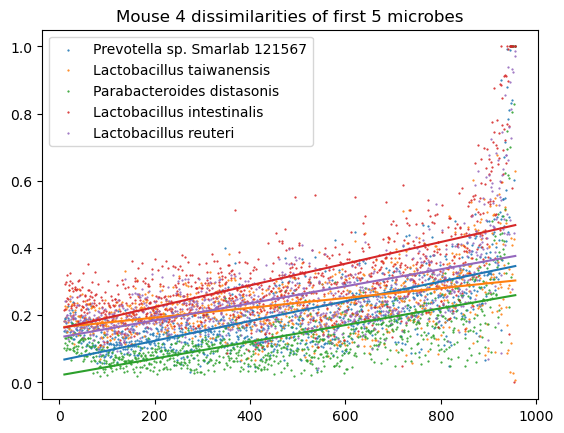

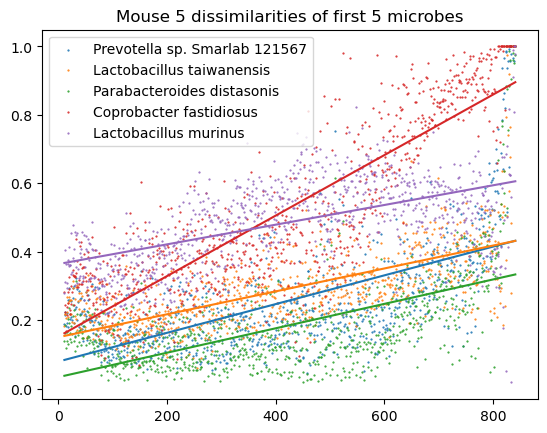

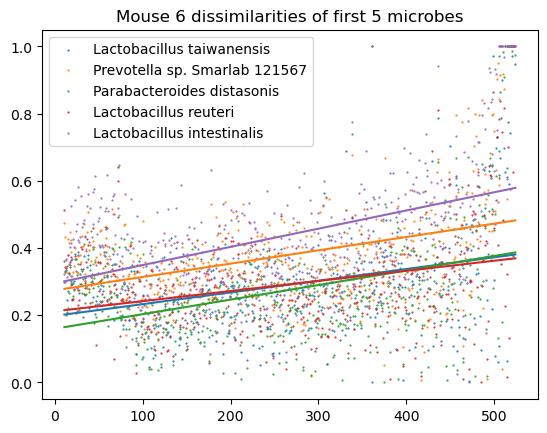

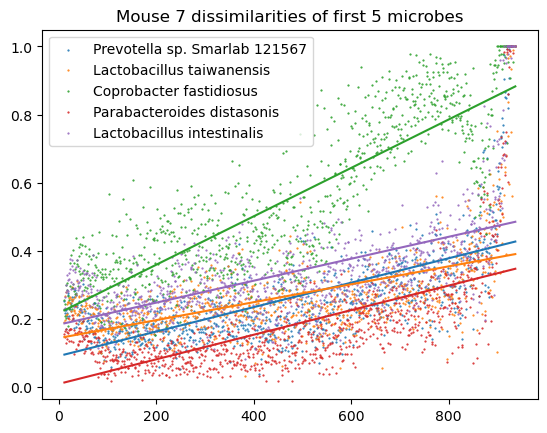

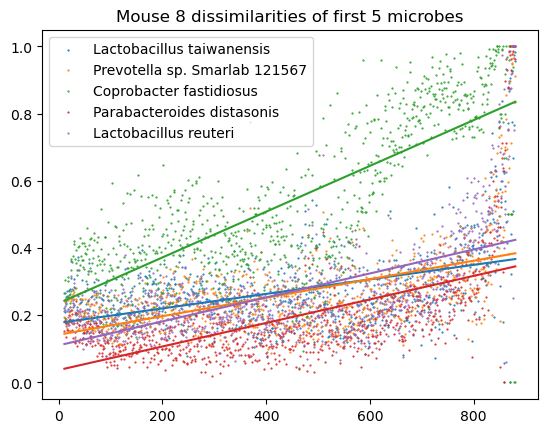

In [ ]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()
        

## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

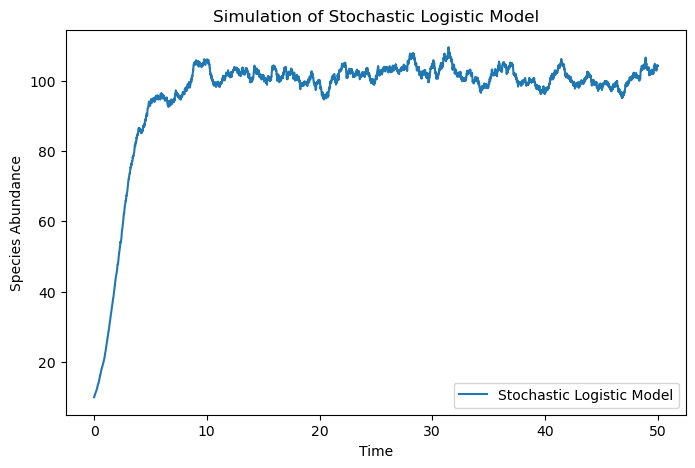

In [5]:
# Fit data of each OTU with SLM to get the parameters estimated for each OTU

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(steps + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = 0.01  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt, steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show()

In [ ]:
# Let's now fit this SLM simulation to our empirical time series (remember that data is stored in mice_diss)

# Let's first try with only the first species of the first mice
df = mice_diss[0]
species = df.index
time_series = df.loc[species[0]]
days = np.asarray(df.columns, dtype = int)
dt = [days[i+1] - days[i] for i in range(0, len(days) - 1)]
tau = 1

### FROM HERE TO MODIFY 

# Procedure (requires time_series, dt and tau)
def objective(params, time_series, dt, tau): 
    K, sigma = params
    simulated_data = simulate_SLM(ab0 = time_series[0], K = K, sigma = sigma, tau = tau, steps = len(time_series) - 1, dt = dt)
    return np.sum((simulated_data - time_series)**2) # Minimize MSE

bounds = [(time_series.min(), time_series.max()), (0.01, 1)] # Bounds for K and sigma 

result = result = opt.differential_evolution(objective, bounds, args=(time_series, dt, tau), strategy='best1bin') # Optimize using Differential Evolution

K_opt, sigma_opt = result.x # Extract optimal parameters
print("Estimated K:", K_opt)
print("Estimated sigma:", sigma_opt) 

# Another possible procedure isuseing opt.curve_fit BUT that requires initial guesses

/var/folders/5q/jycjzrd11k1gq_4l_z12pgc00000gn/T/ipykernel_1614/1809492083.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulated_data = simulate_SLM(ab0 = time_series[0], K = K, sigma = sigma, tau = tau, steps = len(time_series) - 1, dt = dt)


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
# Sample counts for days for which the individual was sampled

In [ ]:
# Compute the dissimilarity for the simulated data 

In [ ]:
# Compute the slope obtained for the dissimilarity of simulated data

In [ ]:
# Compute the treshold for each individual as the 95% quantile of the slopes obtained for that individual

## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

        - if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
        so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

        calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.
